In [1]:
# For this notebook, we've picked an instance of maxcut. Other problems are more interesting,
# but this is the one always used in the literature.

# The goal here is to setup a Maxcut QAOA instance using qiskit, and execute it on the qiskit simulator
# using the ColdQuanta API. To validate our results, we will look for the canonical ``qaoa landscape" and 
# see that it loses contrast when the noise is increased.

In [285]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
# Set up a 2x2 grid topology.
rows = 2
cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

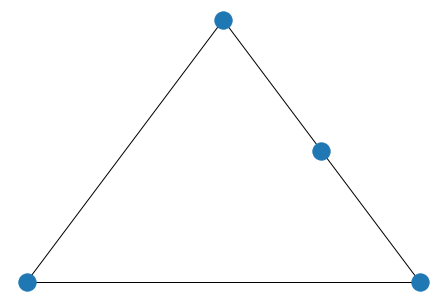

In [286]:
from networkx import Graph, draw_planar
g = Graph(coupling_map)
draw_planar(g)

In [287]:
# We will currently only accept QAOA instances on graphs isomorphic to our own -
# i.e. we are not implementing a compiler. Provide them as a dictionary.

# Uniform weights.
weights = {tuple(k): 1 for k in coupling_map}

In [288]:
# It looks like Qiskit hasn't implemented any kind of exponentiation - 
# in particular, they write to use "an Ising-type gate":
# https://qiskit.org/textbook/ch-applications/qaoa.html#2.1-(weighted)-$MAXCUT$
# Rigetti has implemented an exponentiate-like feature -
# http://docs.rigetti.com/en/stable/apidocs/autogen/pyquil.paulis.exponentiate.html#pyquil.paulis.exponentiate

# For this example, everything is diagonal and we are free to just compute the QAOA circuit from the weights.
# Taking from the qiskit tutorial:
from qiskit import QuantumCircuit
def qaoa_circuit(gamma, beta):
    QAOA = QuantumCircuit(rows*cols)
    # apply the layer of Hadamard gates to all qubits, and then fence all qubits.
    QAOA.h(range(rows*cols))
    QAOA.barrier()

    # apply the Ising type gates with angle gamma along the edges in E
    
    #HACK, we need to remove redundant edges.
    visited = set()
    for edge, weight in weights.items():
        if (min(edge), max(edge)) in visited:
            continue
        visited.add((min(edge), max(edge)))
        k = edge[0]
        l = edge[1]
        # The following is a gate decomposition for a exp(-i*\gamma*ZZ). **UNVERIFIED**.
        # Controlled-U1 gate - i.e. Controlled phase.
        QAOA.h(l)
        QAOA.cz(k, l)
        QAOA.h(l)
        QAOA.rz(2*gamma*weight, l)
        QAOA.h(l)
        QAOA.cz(k, l)
        QAOA.h(l)
        # These phases were fucking it up. In fact, we didn't want a CPHASE in the first place. 
        #QAOA.rz(-gamma*weight, k)
        #QAOA.rz(-gamma*weight, l)
        QAOA.barrier()

    # then apply the single qubit X - rotations with angle beta to all qubits

    
    #\exp^{-i\beta\sigma_x} = RX(2*\beta), so the factor of two keeps us consistent with https://arxiv.org/pdf/1411.4028 
    QAOA.rx(beta*weight, list(range(rows*cols)))
    QAOA.measure_all()
    return QAOA


In [289]:
qaoa_circuit(0,0).draw()

┌───┐ ░                                     ░                       »
   q_0: ┤ H ├─░───────■─────────────────────■───────░───────────────────────»
        ├───┤ ░ ┌───┐ │ ┌───┐┌───────┐┌───┐ │ ┌───┐ ░                       »
   q_1: ┤ H ├─░─┤ H ├─■─┤ H ├┤ RZ(0) ├┤ H ├─■─┤ H ├─░───────────────────────»
        ├───┤ ░ └───┘   └───┘└───────┘└───┘   └───┘ ░                       »
   q_2: ┤ H ├─░─────────────────────────────────────░───────■───────────────»
        ├───┤ ░                                     ░ ┌───┐ │ ┌───┐┌───────┐»
   q_3: ┤ H ├─░─────────────────────────────────────░─┤ H ├─■─┤ H ├┤ RZ(0) ├»
        └───┘ ░                                     ░ └───┘   └───┘└───────┘»
meas_0: ════════════════════════════════════════════════════════════════════»
                                                                            »
meas_1: ════════════════════════════════════════════════════════════════════»
                                                                            »
meas_2: ════════════════════════════════════════════════════════════════════»
                                                                            »
meas_3: ════════════════════════════════════════════════════════════════════»
                                                                            »
«                      ░                                     ░              »
«   q_0: ──────────────░───────■─────────────────────■───────░──────────────»
«                      ░       │                     │       ░              »
«   q_1: ──────────────░───────┼─────────────────────┼───────░───────■──────»
«                      ░ ┌───┐ │ ┌───┐┌───────┐┌───┐ │ ┌───┐ ░       │      »
«   q_2: ──────■───────░─┤ H ├─■─┤ H ├┤ RZ(0) ├┤ H ├─■─┤ H ├─░───────┼──────»
«        ┌───┐ │ ┌───┐ ░ └───┘   └───┘└───────┘└───┘   └───┘ ░ ┌───┐ │ ┌───┐»
«   q_3: ┤ H ├─■─┤ H ├─░─────────────────────────────────────░─┤ H ├─■─┤ H ├»
«        └───┘   └───┘ ░                                     ░ └───┘   └───┘»
«meas_0: ═══════════════════════════════════════════════════════════════════»
«                                                                           »
«meas_1: ═══════════════════════════════════════════════════════════════════»
«                                                                           »
«meas_2: ═══════════════════════════════════════════════════════════════════»
«                                                                           »
«meas_3: ═══════════════════════════════════════════════════════════════════»
«                                                                           »
«                               ░ ┌───────┐ ░ ┌─┐         
«   q_0: ───────────────────────░─┤ RX(0) ├─░─┤M├─────────
«                               ░ ├───────┤ ░ └╥┘┌─┐      
«   q_1: ───────────────■───────░─┤ RX(0) ├─░──╫─┤M├──────
«                       │       ░ ├───────┤ ░  ║ └╥┘┌─┐   
«   q_2: ───────────────┼───────░─┤ RX(0) ├─░──╫──╫─┤M├───
«        ┌───────┐┌───┐ │ ┌───┐ ░ ├───────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤ RZ(0) ├┤ H ├─■─┤ H ├─░─┤ RX(0) ├─░──╫──╫──╫─┤M├
«        └───────┘└───┘   └───┘ ░ └───────┘ ░  ║  ║  ║ └╥┘
«meas_0: ══════════════════════════════════════╩══╬══╬══╬═
«                                                 ║  ║  ║ 
«meas_1: ═════════════════════════════════════════╩══╬══╬═
«                                                    ║  ║ 
«meas_2: ════════════════════════════════════════════╩══╬═
«                                                       ║ 
«meas_3: ═══════════════════════════════════════════════╩═
«

In [290]:
def estimate_cost(counts, weights):
    cost = 0
    for assignment, count in counts.items():
        for edge, weight in weights.items():
            if assignment[edge[0]] != assignment[edge[1]]:
                # We've cut this edge.
                cost += weight*count
    # The coupling map currently includes both directions for all couplings. Since we've assumed an undirected
    # graph, we just divide by two.
    cost /= 2
    return cost/sum(counts.values()) 

In [291]:
import numpy as np
discretization = 15
max_gamma = max_beta = np.pi
gammas = np.linspace(0, max_gamma, discretization)
betas = np.linspace(0, max_beta, discretization)

In [292]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(qaoa_circuit(gamma, beta))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [293]:
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

2.990234375
1.017578125


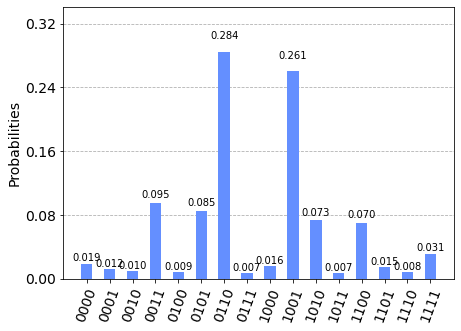

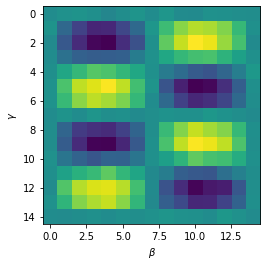

In [294]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(landscape)
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
print(np.max(landscape))
print(np.min(landscape))
plot_histogram(all_counts[np.argmax(landscape)])

# Now introduce noise!

In [295]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

In [296]:
noise_model = create_noise_model()

In [297]:
noise_model

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u3']
  Instructions with noise: ['r', 'cz', 'id', 'rz']
  All-qubits errors: ['r', 'rz', 'id', 'cz']

In [298]:
noise_model = create_noise_model(cz_fidelity=0.7)

experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(qaoa_circuit(gamma, beta))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  
all_counts = job.result().get_counts()

In [299]:
noisy_landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

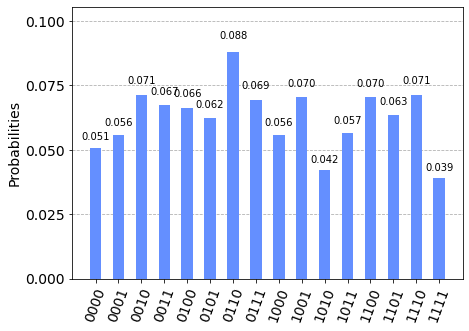

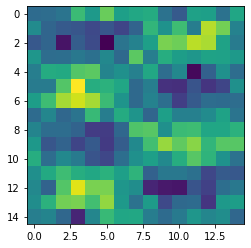

In [300]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(noisy_landscape)
plot_histogram(all_counts[np.argmax(noisy_landscape)])

# Include Classical Optimizer

In [284]:
from scipy.optimize import minimize

def execute_qaoa_circuit_and_estimate_cost(gamma, beta, num_shots, simulator, coupling_map, weights, *, noise_model=None):
    circuit = qaoa_circuit(gamma, beta)
    job = execute(circuit,
                  simulator,
                  noise_model=noise_model,
                  coupling_map=coupling_map,
                  optimization_level=0,
                  shots=num_shots)  
    all_counts = job.result().get_counts()
    return estimate_cost(all_counts, weights)

In [260]:
simulator = Aer.get_backend('qasm_simulator')
shots_per_point = 1000

# HACK, history will need to be reinitialized everytime the optimizer is called.
def store_log(func):
    def logged_func(x):
        history.append(x)
        return func(x)
    return logged_func

@store_log
def gamma_beta_objective(gamma_beta):
    return -execute_qaoa_circuit_and_estimate_cost(gamma=gamma_beta[0], beta=gamma_beta[1], num_shots=shots_per_point,
                                                   simulator=simulator,
                                                   coupling_map=neutral_atom_config.coupling_map,
                                                   weights=weights)

In [261]:
def gamma_beta_to_index(gamma, beta, discretization):
    return (gamma * discretization/max_gamma)%(discretization-1), (beta * discretization/max_beta)%(discretization-1)
def plot_history_over_landscape(history, landscape, discretization):
    plt.imshow(landscape)
    plt.colorbar()
    for i, point in enumerate(history[1:-1]):
        plt.scatter(*gamma_beta_to_index(*point, discretization), c='r')
    plt.scatter(*gamma_beta_to_index(*history[0], discretization), marker='.', s=200, c='w')
    plt.scatter(*gamma_beta_to_index(*history[-1], discretization), marker='*', s=200, c='w')

In [262]:
def try_optimizer(optimizer):
    global history
    history = []
    initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
    result = minimize(gamma_beta_objective, x0=initial_gamma_beta, method=optimizer)
    plot_history_over_landscape(history, landscape, discretization)
    plt.title(optimizer)
    plt.show()

In [263]:
methods = ['Nelder-Mead',
           'Powell',
           'CG',
           'BFGS',
           # 'Newton-CG',
           'L-BFGS-B',
           'TNC', 
           'COBYLA',
           'SLSQP',
           'trust-constr',
           #'dogleg',
           #'trust-ncg',
           #'trust-krylov',
           #'trust-exact'
          ]

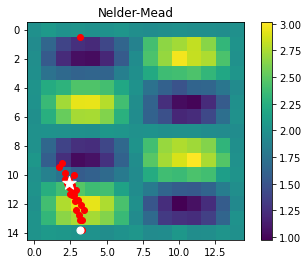

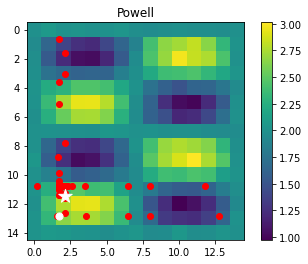

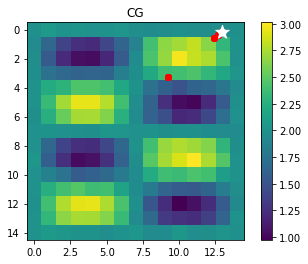

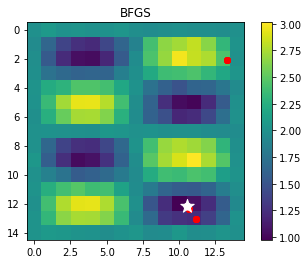

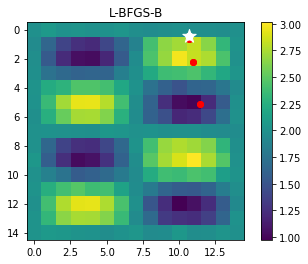

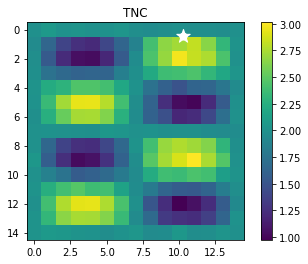

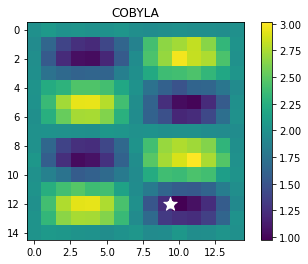

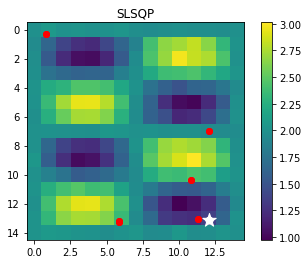

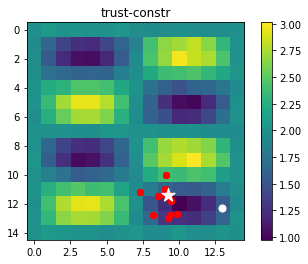

In [267]:
for method in methods:
    try_optimizer(method)